# 2D to 3D LSTM

This is the first approach to try to estimate 3D points coordinates from 2D keypoints extracted with Openpose. Here I will build a simple LSTM to perform the task over the Panoptic Studio dataset.

First, let's import all the necessary libraries.

In [1]:
# Pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Plotting utilities
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation

# Directory and file utilities
from os import listdir
from os.path import isfile, isdir, join
import json

## Data acquisition
Now I will define some functions in order to parse and organise the data, and later convert it to pytorch tensors.

The data is structured as follows: in the dataset directory there are several folders, each folder corresponds to a recording; each of these folders contains a folder with the audio, folders with face, hands and body keypoints estimations for each frame, and a folder with the video recorded from different views.

In this first approach I will be using the keypoints estimations. Every keypoint folder (face, hands or body) is organized the same way: it contains a json per frame of the video, which includes the 3D keypoints estimation.

The function `get_keypoints` will go through each folder in the dataset directory and retrieve the face keypoints, the hands keypoints and the body keypoints. It will separate them into input (2D coordinates per joint per frame) and grountruth (third coordinate to estimate for each input 2D keypoint). 
The input will be of shape $([n videos, seq len, input size])$, where *seq_len* = number of frames, and *input_size* = face + hands + body keypoints, that is (70+(21+21)+26)x2 -multiplied by 2 because there are x and y coordinates-. The groundtruth (label) data will be of the same shape, except that the last dimension size will not be multiplied by 2 (there's only one coordinate to estimate).  

In [2]:
def get_keypoints(data_path):
    dataset = []
    groundtruth = []
    # Look over just the folders inside the directory
    just_folders = filter(lambda x: isdir(join(data_path, x)), listdir(data_path))
    for p in list(map(lambda x: join(data_path, x), just_folders)): 
        # Gets 2 list of n_frames lists, one for the 2D coordinates and one for the third coordinate.
        # Each list of the n_frames lists contains, either the (x and y) or the z of each keypoint for the face(first line), hands(second), body(third).
        # e.g. the first line will result in [[x1,y1,x2,y2...x70,y70]sub1...[x1,y1...x70,y70]subN], [[z1,z2...z70]sub1...[z1..z70]subN]
        # Actually, as there will be two of each list above because there are two people en each video.
        pose_2d, pose_3d = get_body(p)
        
        # Concatenates the coordinates for the face, hands and body on the last dimension, for each person.
        vid_input_p1, vid_input_p2 = pose_2d
        vid_labels_p1, vid_labels_p2 = pose_3d
        
        dataset.append(vid_input_p1)
        dataset.append(vid_input_p2)
        groundtruth.append(vid_labels_p1)
        groundtruth.append(vid_labels_p2)
        print(f'Completed folder {p}')
    return dataset, groundtruth

The body json is organised a bit differently, inside each person object contains the *joints26* field with a list of 3D coordinates. But this list is structured as follows: *[x1,y1,z1,acc1,x2,y2,z2,acc2...]*.

In [3]:
def get_body(path):
    body_2D_seq = ([], [])
    body_3D_seq = ([], [])
    paths = map(lambda x: join(path, 'hdPose3d_stage1_op25', x), sorted(listdir(join(path, 'hdPose3d_stage1_op25'))))
    files = list(filter(lambda x: isfile(x), paths))
    for f in files[:-1]:
        with open(f, 'r') as j:
            json_array = json.load(j)
            i = 0
            for person in json_array['bodies']:
                if person['id'] != -1:
                    x = person['joints26'][::4]
                    y = person['joints26'][1::4]
                    two_coord = [l[item] for item in range(len(x)) for l in [x,y]]
                    third_coord = person['joints26'][2::4]
                    body_2D_seq[i].append(two_coord)
                    body_3D_seq[i].append(third_coord)
                    i += 1
            if i<2:
                body_2D_seq[i].append([0. for i in range(52)])
                body_3D_seq[i].append([0. for i in range(26)])
    print('Body completed.')
    return body_2D_seq, body_3D_seq

In [4]:
data_path = '../../../data/DB keypoints'
dataset, groundtruth = get_keypoints(data_path)

Body completed.
Completed folder ../../../data/DB keypoints/190419_asl2
Body completed.
Completed folder ../../../data/DB keypoints/190419_asl4
Body completed.
Completed folder ../../../data/DB keypoints/190419_asl5
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl1
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl2
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl3
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl5
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl7
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl9
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl91
Body completed.
Completed folder ../../../data/DB keypoints/190611_asl1
Body completed.
Completed folder ../../../data/DB keypoints/190611_asl2
Body completed.
Completed folder ../../../data/DB keypoints/190611_asl3


## Dataset structuring
Now let's convert the lists obtained to Pytorch tensors and organise them in train, validation and test datasets. 
First, I will define a padding function in order to make all the sequences of video frames the same length, so I can train the LSTM in batches. 

In [5]:
def padding_seq(dataset):
    max_seq = max([len(x) for x in dataset])
    for seq in dataset:
        for i in range(max_seq-len(seq)):
            seq.append([np.nan for j in range(len(seq[0]))])
    return max_seq

max_seq = padding_seq(dataset)
padding_seq(groundtruth)

8751

In [6]:
# From python lists to numpy ndarray.
dataset = np.asarray(dataset)
groundtruth = np.asarray(groundtruth)
print(dataset.shape, groundtruth.shape)

(26, 8751, 52) (26, 8751, 26)


In [7]:
def norm_uniform(tensor, coordinates=1):
    max_value = [np.nanmax(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    min_value = [np.nanmin(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    center = [(max_value[i]+min_value[i])/2 for i in range(coordinates)]
    for j in range(coordinates):
        subtensor = tensor[:, :, j::coordinates]
        subtensor[:] = np.subtract(subtensor, center[j])
        subtensor[:] = np.divide(subtensor, max_value[j]-center[j])

norm_uniform(dataset,2)
norm_uniform(groundtruth)

For each axis I normalize the keypoints using the following formula:

In [8]:
def normalize(tensor, coordinates=1):
    mean_value = [np.nanmean(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    std_value = [np.nanstd(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    for j in range(coordinates):
        subtensor = tensor[:, :, j::coordinates]
        subtensor[:] = np.subtract(subtensor, mean_value[j])
        subtensor[:] = np.divide(subtensor, std_value[j])
  
    return [(mean_value[i], std_value[i]) for i in range(coordinates)]

mom_x, mom_y = normalize(dataset, 2)
print(mom_x, mom_y)
mz, stdz = normalize(groundtruth)[0]

(0.013527003297416726, 0.33311028306307217) (0.11563418274515538, 0.6407305403722219)


In [9]:
# From python lists to pytorch tensors.
dataset = torch.tensor(np.nan_to_num(dataset), dtype=torch.float32)
groundtruth = torch.tensor(np.nan_to_num(groundtruth), dtype=torch.float32)
print(dataset.shape, groundtruth.shape)

torch.Size([26, 8751, 52]) torch.Size([26, 8751, 26])


In [10]:
l1, l2 = len(dataset), len(groundtruth)
# Split in train, validation and test
training_kp, val_kp, test_kp = dataset[:round(0.7*l1)], dataset[round(0.7*l1):round(0.85*l1)], dataset[round(0.85*l1):]
training_lbl, val_lbl, test_lbl = groundtruth[:round(0.7*l2)], groundtruth[round(0.7*l2):round(0.85*l2)], groundtruth[round(0.85*l2):]
print(training_kp.shape, val_kp.shape, test_kp.shape)
print(training_lbl.shape, val_lbl.shape, test_lbl.shape)

torch.Size([18, 8751, 52]) torch.Size([4, 8751, 52]) torch.Size([4, 8751, 52])
torch.Size([18, 8751, 26]) torch.Size([4, 8751, 26]) torch.Size([4, 8751, 26])


Finally we define the batch_size and put the datasets in DataLoaders.

In [11]:
train_data = TensorDataset(training_kp, training_lbl)
val_data = TensorDataset(val_kp, val_lbl)
test_data = TensorDataset(test_kp, test_lbl)

batch_size = 2

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

print(train_loader)

If we have a GPU available we set our device to GPU.

In [12]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Let's print some examples to see whether it is loaded correctly or not.

In [13]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print(sample_x.shape, sample_y.shape)

torch.Size([2, 8751, 52]) torch.Size([2, 8751, 26])


## Model building
It is time to build the model for this approach. It will consist on a single/double layer LSTM followed by a Linear layer with output size the number of keypoints we want to estimate. I also define a method to initialize the hidden_state of the cell.

In [14]:
class LSTM_2D3D(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        # Save the model parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Define the architecture
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_size),
            nn.ReLU()
        )
        
    def forward(self, x, state):
        # Describe the forward step
        batch_size, seq_len = x.size(0), x.size(1) # We save the batch size and the sequence length
        ht, hidden_state = self.lstm(x, state)
        ht = ht.contiguous().view(-1, self.hidden_dim) # Need to flatten and reshape the output to feed it to the Linear layer
        ot = self.fc(ht)
        ot = ot.view(batch_size, seq_len, -1) # Reshape the output for it to be torch.Size([batch_size, seq_len, output_size])
        return ot, hidden_state
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [15]:
# Define some model parameters
INPUT_SIZE = sample_x.size(2)
OUTPUT_SIZE = sample_y.size(2)
HIDDEN_DIM = 512
N_LAYERS = 1

# Instantiate the model
model = LSTM_2D3D(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_DIM, N_LAYERS)
model.to(device)
print(model)

LSTM_2D3D(
  (lstm): LSTM(52, 512, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=26, bias=True)
    (1): ReLU()
  )
)


## Training
Now we will proceed with the training. The first cell will define the learning rate, the loss function and the selected optimizer for the training process. Then we will proceed with a training over a number of epochs in which we will print it's training loss and validation loss. I also will be using Tensorboard to have a much nicer view of the results.

In [16]:
def substract_root_PJPE(output):
    jb = torch.chunk(output, max_seq, dim=1)
    root = 8
    n_joints = []
    for chunk in jb:
        n_joints.append(chunk.sub(chunk[:,:,root].unsqueeze(2)))
    joints_merged = torch.cat(tuple(n_joints), dim=1)
    return joints_merged

In [17]:
lr = 1e-4
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
from datetime import datetime
name = 'body_whole'
writer = SummaryWriter(log_dir=f'/deeplearning/logs/{name}{datetime.now()}_lr-{lr}')

Finished epoch 1/15 in 12.09s.
 Loss: 0.9533  Val Loss: 0.5930
Train MPJPE: 0.0688  Val MPJPE: 0.0541
Finished epoch 2/15 in 12.10s.
 Loss: 0.8842  Val Loss: 0.5570
Train MPJPE: 0.0813  Val MPJPE: 0.0621
Finished epoch 3/15 in 12.13s.
 Loss: 0.8070  Val Loss: 0.5014
Train MPJPE: 0.1035  Val MPJPE: 0.0797
Finished epoch 4/15 in 12.15s.
 Loss: 0.6857  Val Loss: 0.4653
Train MPJPE: 0.1608  Val MPJPE: 0.1070
Finished epoch 5/15 in 12.18s.
 Loss: 0.6881  Val Loss: 0.4631
Train MPJPE: 0.2292  Val MPJPE: 0.1111
Finished epoch 6/15 in 12.23s.
 Loss: 0.6606  Val Loss: 0.4878
Train MPJPE: 0.1958  Val MPJPE: 0.0950
Finished epoch 7/15 in 12.18s.
 Loss: 0.6441  Val Loss: 0.4896
Train MPJPE: 0.1900  Val MPJPE: 0.1058
Finished epoch 8/15 in 12.23s.
 Loss: 0.6233  Val Loss: 0.4936
Train MPJPE: 0.2124  Val MPJPE: 0.1063
Finished epoch 9/15 in 12.13s.
 Loss: 0.6158  Val Loss: 0.4941
Train MPJPE: 0.2159  Val MPJPE: 0.1079
Finished epoch 10/15 in 12.13s.
 Loss: 0.6146  Val Loss: 0.4932
Train MPJPE: 0.208

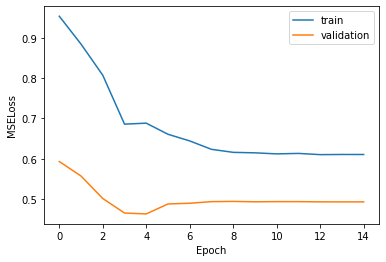

In [19]:
NUM_EPOCHS = 15
train_its = int(np.ceil(training_kp.size(0)/batch_size))
timer_beg = timer()
tr_losses = []

val_losses = []

model.train()
for i in range(NUM_EPOCHS):
    # Init the hidden state (ht, ct)
    h = model.init_hidden(batch_size)
    batch_losses = []
    train_MPJPE = []
    if i+1 == NUM_EPOCHS:
        preds, inps, labls = [], [], []
        val_preds, val_inps, val_labls = [], [], []
    for inputs, labels in train_loader:
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward step
        output, h = model(inputs, h)
        if i+1 == NUM_EPOCHS:
            preds.append(output)
            inps.append(inputs)
            labls.append(labels)
        # Loss calculation and backward step
        loss = loss_function(output, labels.float())
        loss.backward()
        # Weight update
        optimizer.step()
        
        # Output data collection for showing
        batch_losses.append(loss.item())
        rooted_o, rooted_l = substract_root_PJPE(output), substract_root_PJPE(labels)
        train_MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())
    
    if i+1 == NUM_EPOCHS: 
        tr_predictions = torch.cat(tuple(preds), dim=0)
        tr_inputs = torch.cat(tuple(inps), dim=0)
        tr_groundtruth = torch.cat(tuple(labls), dim=0)
    timer_end = timer()
    tr_losses.append(np.mean(batch_losses))
    writer.add_scalar('Loss/train', tr_losses[-1], i)   
    train_MPJPE_total = np.mean(train_MPJPE)
    
    # Validation at the end of an epoch
    val_h = model.init_hidden(batch_size)
    model.eval()
    val_loss = []
    val_MPJPE = []
    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        if i+1 == NUM_EPOCHS:
            val_preds.append(output)
            val_inps.append(inp)
            val_labls.append(lab)
        val_loss.append(loss_function(out, lab.float()).item())
        rooted_o, rooted_l = substract_root_PJPE(out), substract_root_PJPE(lab)
        val_MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())
    
    if i+1 == NUM_EPOCHS: 
        val_predictions = torch.cat(tuple(val_preds), dim=0)
        val_inputs = torch.cat(tuple(val_inps), dim=0)
        val_groundtruth = torch.cat(tuple(val_labls), dim=0)
    val_losses.append(np.mean(val_loss))
    writer.add_scalar('Loss/validation', val_losses[-1], i)  
    val_MPJPE_total = np.mean(val_MPJPE)
    model.train()
    
    # Output loss and training time.
    print(f"Finished epoch {i+1}/{NUM_EPOCHS} in {(timer_end-timer_beg):.2f}s.\n",
             f"Loss: {np.mean(tr_losses[-1]):.4f}",
             f" Val Loss: {val_losses[-1]:.4f}\n"
             f"Train MPJPE: {train_MPJPE_total*stdz:.4f}", f" Val MPJPE: {val_MPJPE_total*stdz:.4f}")
    timer_beg = timer()

plt.plot(tr_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.legend()

In [20]:
zeros = torch.zeros((26), device='cuda:0')
count=0
for i in range(len(tr_predictions)):
    for frame in tr_predictions[i]:
        if torch.all(frame.eq(zeros)):
            count +=1
    print(count, end=' ')
    count=0
    for frame in tr_groundtruth[i]:
        if torch.all(frame.eq(zeros)):
            count +=1
    print(f'vs. {count}')

6959 vs. 1798
1962 vs. 0
0 vs. 480
8877 vs. 136
7191 vs. 1125
1125 vs. 479
9230 vs. 0
513 vs. 0
60 vs. 1798
7652 vs. 2720
10998 vs. 479
479 vs. 0
5850 vs. 2906
11173 vs. 479
479 vs. 1798
1798 vs. 2906
2906 vs. 479
8744 vs. 479


In [21]:
print(stdz)

0.4366311369131177


In [22]:
torch.save(model.state_dict(), f'./{name}.pt')

In [23]:
model.load_state_dict(torch.load(f'./{name}.pt'))

<All keys matched successfully>

## Testing
After the training, we shall proceed with the performance test. This will go through the test batches and perform the inference, then it will show the test loss, as well as the performance metric. In this case, as we are working with human body keypoints, we will use the Mean Per Joint Position Error (MPJPE) metric, which outputs the mean euclidean distance between the joints (keypoints) positions estimated and the ones in the groundtruth.

The formula for MPJPE is the following:

$\text{MPJPE} = \frac1T\frac1N\displaystyle\sum_{t=1}^{T}\displaystyle\sum_{i=1}^{N}\|(J_{i}^{(t)}-J_{root}^{(t)})-(Ĵ_{i}^{(t)}-Ĵ_{root}^{(t)})\|$

Where N is the number of joints, and T the number of samples.

As we have seen in the formula above, we need to align the root joints of the labels and the network output. In order to do that, I have defined a function (`substract_root_PJPE`) that substracts the root joint of each keypoint set (face, hands, body) in the corresponding keypoint set.

In [24]:
test_losses = []
MPJPE = []
h = model.init_hidden(batch_size)
preds, inps, labls = [], [], []

model.eval()
for inputs_test, labels_test in test_loader:
    
    h = tuple([each.data for each in h])
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    
    output_test, h = model(inputs_test, h)
    preds.append(output_test)
    inps.append(inputs_test)
    labls.append(labels_test)
    
    test_loss = loss_function(output_test, labels_test.float())
    test_losses.append(test_loss.item())
    rooted_o, rooted_l = substract_root_PJPE(output_test), substract_root_PJPE(labels_test)
    MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())

test_predictions = torch.cat(tuple(preds), dim=0)
test_inputs = torch.cat(tuple(inps), dim=0)
test_groundtruth = torch.cat(tuple(labls), dim=0)
MPJPE_total = np.mean(MPJPE)

In [25]:
print(f"MPJPE: {MPJPE_total*stdz:.4f}", f"\nTest loss: {np.mean(test_losses):.4f}")

MPJPE: 0.0511 
Test loss: 0.5331


## Interpreation

Now to better understanding of the results, I will plot some of the frames from the last batches on the training and validation, and also from testing.

In [26]:
def plot_and_rotate(c_inputs, c_z, frames, frame):
    c_inputs[:,:,::2].mul_(mom_x[1])
    c_inputs[:,:,1::2].mul_(mom_y[1])
    c_z.mul_(stdz)

    bodiesXY = torch.chunk(c_inputs[0, frames, :], len(frames), dim=0)
    bodiesZ = torch.chunk(c_z[0, frames, :], len(frames), dim=0)
    
    x = bodiesXY[frame].squeeze()[::2]
    y = bodiesXY[frame].squeeze()[1::2]
    z = bodiesZ[frame].squeeze()

    l_arm = [[c[i] for i in [1, 0, 9, 10, 11]] for c in [x,y,z]]
    r_arm = [[c[i] for i in [0, 3, 4, 5]] for c in [x,y,z]]
    l_leg = [[c[i] for i in [0, 2, 12, 13, 14, 22, 23, 24]] for c in [x,y,z]]
    r_leg = [[c[i] for i in [2, 6, 7, 8, 19, 20, 21]] for c in [x,y,z]]
    head = [[c[i] for i in [18, 17, 1, 15, 16]] for c in [x,y,z]]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    def init():
        ax.plot(r_arm[0], r_arm[2], r_arm[1])
        ax.plot(l_arm[0], l_arm[2], l_arm[1])
        ax.plot(r_leg[0], r_leg[2], r_leg[1])
        ax.plot(l_leg[0], l_leg[2], l_leg[1])
        ax.plot(head[0], head[2], head[1])
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)

        return fig,

    def animate(i):
        ax.view_init(elev=220., azim=3.6*i)
        return fig,

    # Animate
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

    return ani

In [27]:
def plot_frames(predictions, groundtruth, inputs, video_n, frames):
    
    inp = inputs.clone()
    preds = predictions.clone()
    grtr = groundtruth.clone()
    
    inp[:,:,::2].mul_(mom_x[1])
    inp[:,:,1::2].mul_(mom_y[1])
    preds.mul_(stdz)
    grtr.mul_(stdz)
    
    bodiesXY = torch.chunk(inp[video_n, frames, :], len(frames), dim=0)
    pred_bodiesZ = torch.chunk(preds[video_n, frames, :], len(frames), dim=0)
    true_bodiesZ = torch.chunk(grtr[video_n, frames, :], len(frames), dim=0)
   
    nrows = np.ceil(len(frames)/2)
    fig = plt.figure(figsize=(15, 6*nrows))
    fig2 = plt.figure(figsize=(15, 6*nrows))
    for frame in range(len(frames)):
        x = bodiesXY[frame].squeeze()[::2]
        y = bodiesXY[frame].squeeze()[1::2]
        pred_z = pred_bodiesZ[frame].squeeze()
        true_z = true_bodiesZ[frame].squeeze()

        l_arm = tuple([[c[i] for i in [1, 0, 9, 10, 11]] for c in [x,y,z]] for z in [pred_z, true_z])
        r_arm = tuple([[c[i] for i in [0, 3, 4, 5]] for c in [x,y,z]] for z in [pred_z, true_z])
        l_leg = tuple([[c[i] for i in [0, 2, 12, 13, 14, 22, 23, 24]] for c in [x,y,z]] for z in [pred_z, true_z])
        r_leg = tuple([[c[i] for i in [2, 6, 7, 8, 19, 20, 21]] for c in [x,y,z]] for z in [pred_z, true_z])
        head = tuple([[c[i] for i in [18, 17, 1, 15, 16]] for c in [x,y,z]] for z in [pred_z, true_z])

        ax = fig.add_subplot(nrows, 2, frame+1, projection='3d')

        ax.plot(r_arm[0][0], r_arm[0][2], r_arm[0][1])
        ax.plot(l_arm[0][0], l_arm[0][2], l_arm[0][1])
        ax.plot(r_leg[0][0], r_leg[0][2], r_leg[0][1])
        ax.plot(l_leg[0][0], l_leg[0][2], l_leg[0][1])
        ax.plot(head[0][0], head[0][2], head[0][1])
        
        ax2 = fig2.add_subplot(nrows, 2, frame+1, projection='3d')
        ax2.plot(r_arm[1][0], r_arm[1][2], r_arm[1][1])
        ax2.plot(l_arm[1][0], l_arm[1][2], l_arm[1][1])
        ax2.plot(r_leg[1][0], r_leg[1][2], r_leg[1][1])
        ax2.plot(l_leg[1][0], l_leg[1][2], l_leg[1][1])
        ax2.plot(head[1][0], head[1][2], head[1][1])
        
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        ax2.set_xlim(-1,1)
        ax2.set_ylim(-1,1)
        ax2.set_zlim(-1,1)

        ax.view_init(elev=220., azim=185.)
        ax2.view_init(elev=220., azim=185.)


### Single frame
On the first cell you can select which frames you want to plot and from which video of the batch. On the second you select which frame of the previosly selected you want to plot, specifying its index on the declared "frames" list.

In [28]:
# Last batches of training -output, inputs, labels-.
frames = [200, 3000]

c_inputs = inputs.clone()
c_output = output.clone()
c_labels = labels.clone()

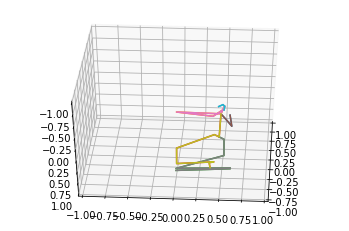

In [29]:
HTML(plot_and_rotate(c_inputs, c_output, frames, 0).to_html5_video())

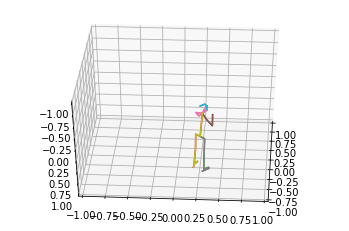

In [30]:
c_inputs = inputs.clone()
HTML(plot_and_rotate(c_inputs, c_labels, frames, 0).to_html5_video())

We repeat the same process for the last test batch.

In [64]:
# Last batches of test -output_test, inputs_test, labels_test-.
frames = [200, 3000]

c_inputs = inputs_test.clone()
c_output = output_test.clone()
c_labels = labels_test.clone()

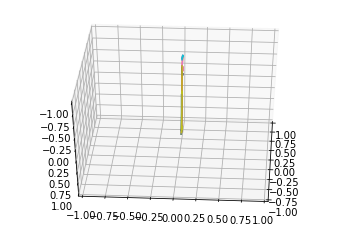

In [65]:
HTML(plot_and_rotate(c_inputs, c_output, frames, 0).to_html5_video())

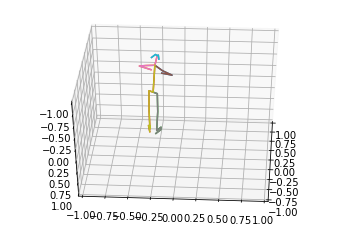

In [66]:
c_inputs = inputs_test.clone()
HTML(plot_and_rotate(c_inputs, c_labels, frames, 0).to_html5_video())

### Slice of frames
Now let's plot a sequence of frames of the selected video. We will plot both the groundtruth and the predicted.

In [76]:
frames = [i for i in range(100,110)]
video_n = 17

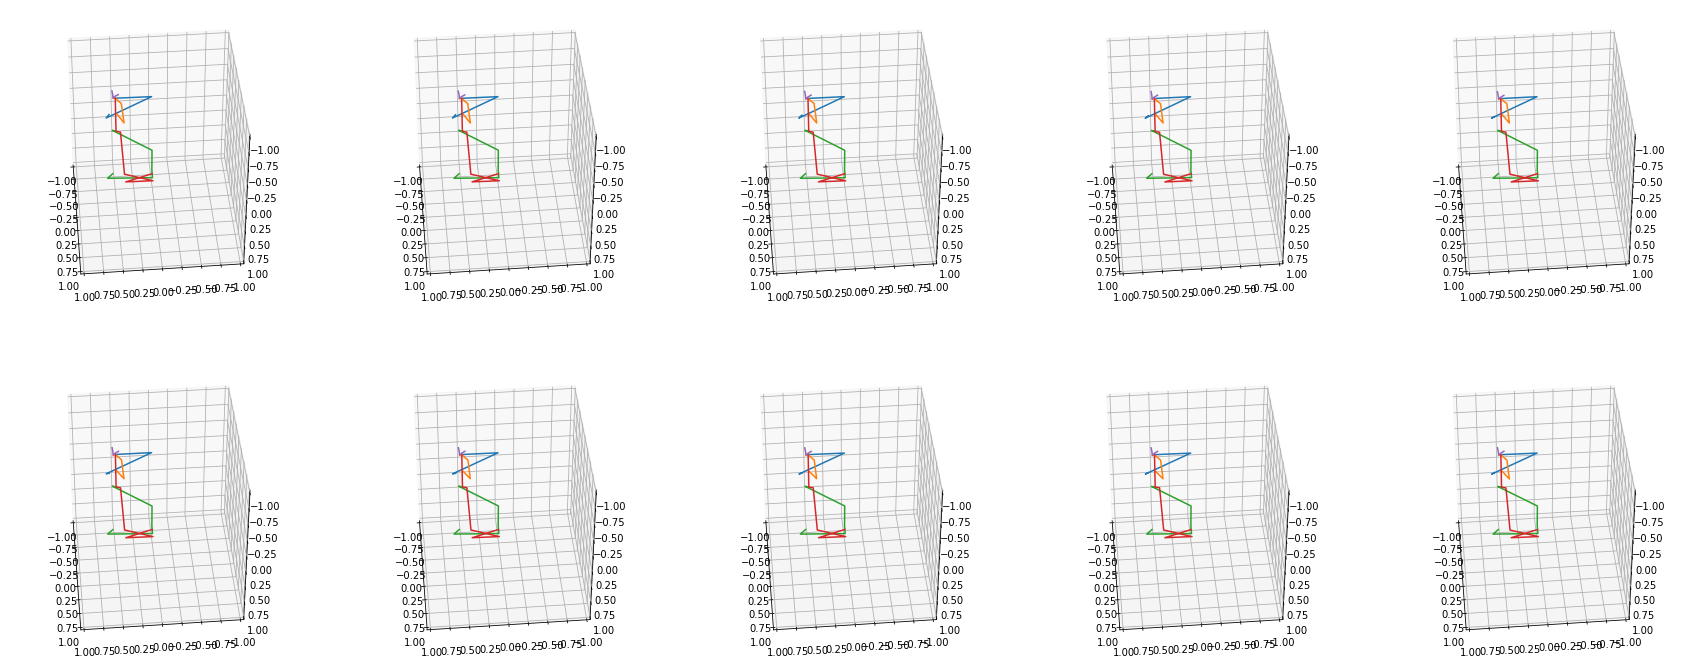

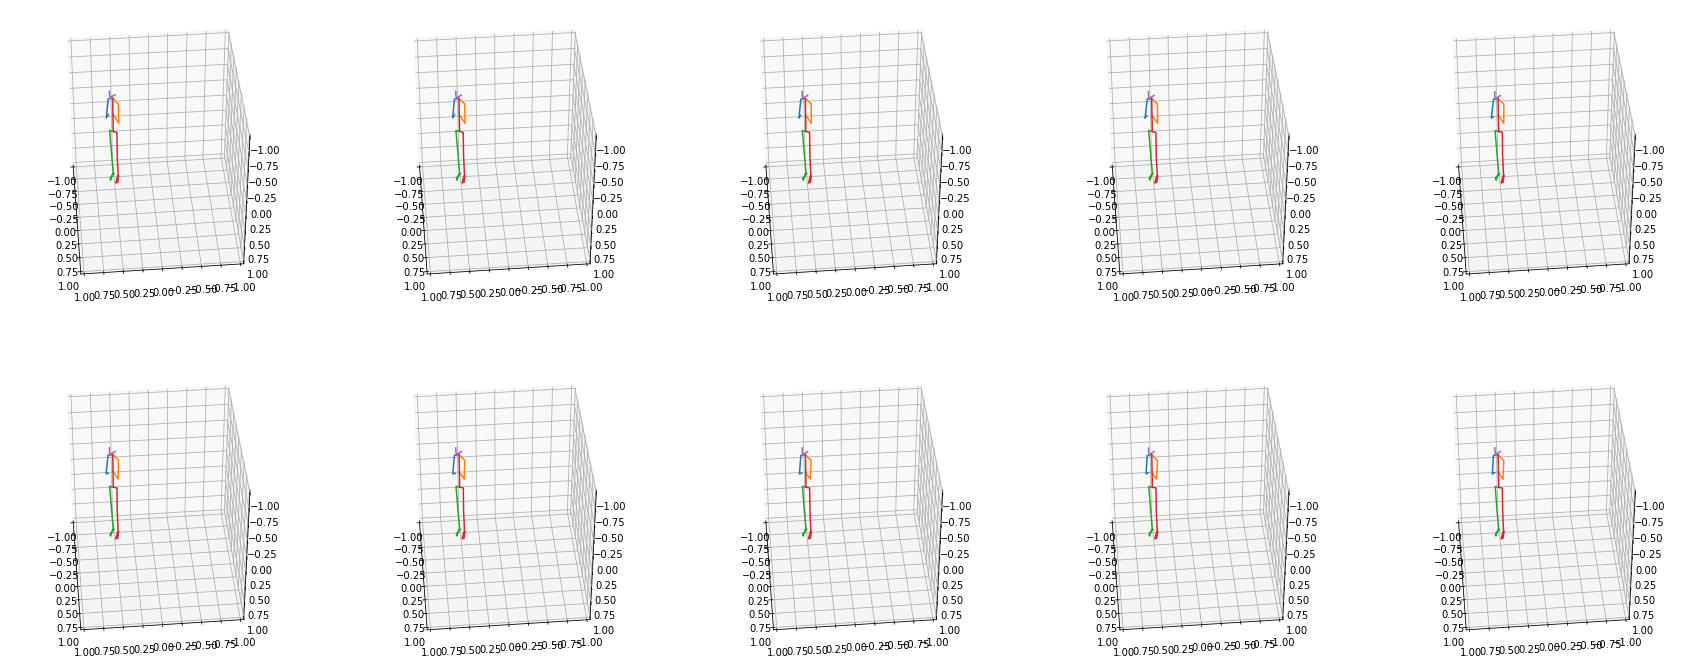

In [77]:
plot_frames(tr_predictions, tr_groundtruth, tr_inputs, video_n, frames)